In [2]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from matplotlib.gridspec import GridSpec


In [5]:
files = [['A1', 'A2'], ['O1', 'O2'], ['I1', 'I2'], ['zvizg_1', 'zvizg_2'], ['erozija_01', 'erozija_02']]

### Analiza z uporabo FFT knjiznice

In [6]:
def numpy_fft_analysis(file: str, energy_cutoff: float = 1.0) -> [np.array, np.array, float, float]:
    signal, fs = sf.read(f'data/{file}.wav')
    N = len(signal)

    Ys = np.fft.fft(signal)[:N//2]
    freq = np.linspace(0, fs, N)[:N//2]

    energy = Ys * np.conj(Ys)
    total_energy = np.sum(energy)
    energy_percentage = (energy / total_energy) * 100.0
    Ys[energy_percentage < energy_cutoff] = 0

    non_zero_energy_freq = freq[np.abs(Ys) > 0]
    min_freq = np.floor(np.min(non_zero_energy_freq))
    max_freq = np.ceil(np.max(non_zero_energy_freq))

    range_idx = np.where((freq >= min_freq) & (freq <= max_freq))
    return Ys[range_idx], freq[range_idx], min_freq, max_freq

### Analiza z uporabo lastnega DFT-ja (Kompleksna sinusoida)

In [7]:
def dftCompelex(file: str, freq_range: tuple[float, float], energy_cutoff: float = 1.0):
    signal, fs = sf.read(f'data/{file}.wav')
    N = len(signal)
    T = N / fs
    t = np.arange(0, T, 1/fs)
    freq_res = 1/T

    freq = np.arange(0, fs, freq_res)[:N//2]
    ys = np.zeros((N//2), dtype=complex)

    min_check_freq = np.floor(freq_range[0] / freq_res) * freq_res
    max_check_freq = np.ceil(freq_range[1] / freq_res) * freq_res

    for f in np.arange(min_check_freq, max_check_freq, 1/T):
        complex_func = np.exp(-1j * 2 * np.pi * t * f)
        amplitude = np.dot(signal, complex_func)
        nearest_idx = np.argmin(np.abs(freq - f))
        ys[nearest_idx] = amplitude

    energy = ys * np.conj(ys)
    energy_percentage = (energy / sum(energy)) * 100.0
    ys[energy_percentage < energy_cutoff] = 0
    range_idx = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]))

    return ys[range_idx], freq[range_idx]


### Analiza z uporabo lasnega DFT-ja - 2 Realni sinusoidi

In [8]:
def dft2Real(file: str, freq_range: tuple[float, float], energy_cutoff: float = 1.0):
    signal, fs = sf.read(f'data/{file}.wav')
    N = len(signal)
    T = N / fs
    t = np.arange(0, T, 1 / fs)
    freq_res = 1/T

    freq = np.arange(0, fs, freq_res)[:N // 2]
    ys = np.zeros((N // 2))

    min_check_freq = np.floor(freq_range[0] / freq_res) * freq_res
    max_check_freq = np.ceil(freq_range[1] / freq_res) * freq_res

    for f in np.arange(min_check_freq, max_check_freq, freq_res):
        sin = np.sin(2 * np.pi * t * f)
        cos = np.cos(2 * np.pi * t * f)

        real_component = np.dot(cos, signal)
        imag_component = np.dot(sin, signal)

        amplitude = np.sqrt(real_component ** 2 + imag_component ** 2)
        nearest_idx = np.argmin(np.abs(freq - f))
        ys[nearest_idx] = amplitude

    energy = ys ** 2
    energy_percentage = (energy / sum(energy)) * 100.0
    ys[energy_percentage < energy_cutoff] = 0

    range_idx = np.where((freq >= min_check_freq) & (freq <= max_check_freq))

    return ys[range_idx], freq[range_idx]

### Analiza z uporabo lasnega DFT-ja - 1 Realen sin

In [9]:
def dft1Real(file: str, freq_range: tuple[float, float], energy_cutoff: float = 1.0):
    signal, fs = sf.read(f'data/{file}.wav')
    N = len(signal)
    T = N / fs
    t = np.arange(0, T, 1 / fs)
    freq_res = 1/T

    freq = np.arange(0, fs, freq_res)[:N // 2]
    ys = np.zeros((N // 2))

    min_check_freq = np.floor(freq_range[0] / freq_res) * freq_res
    max_check_freq = np.ceil(freq_range[1] / freq_res) * freq_res

    for f in np.arange(min_check_freq, max_check_freq, freq_res):
        sin = np.sin(2 * np.pi * t * f)
        amplitude = np.dot(sin, signal)
        nearest_idx = np.argmin(np.abs(freq - f))
        ys[nearest_idx] = amplitude

    energy = ys ** 2
    energy_percentage = (energy / sum(energy)) * 100.0
    ys[energy_percentage < energy_cutoff] = 0

    range_idx = np.where((freq >= min_check_freq) & (freq <= max_check_freq))

    return ys[range_idx], freq[range_idx]

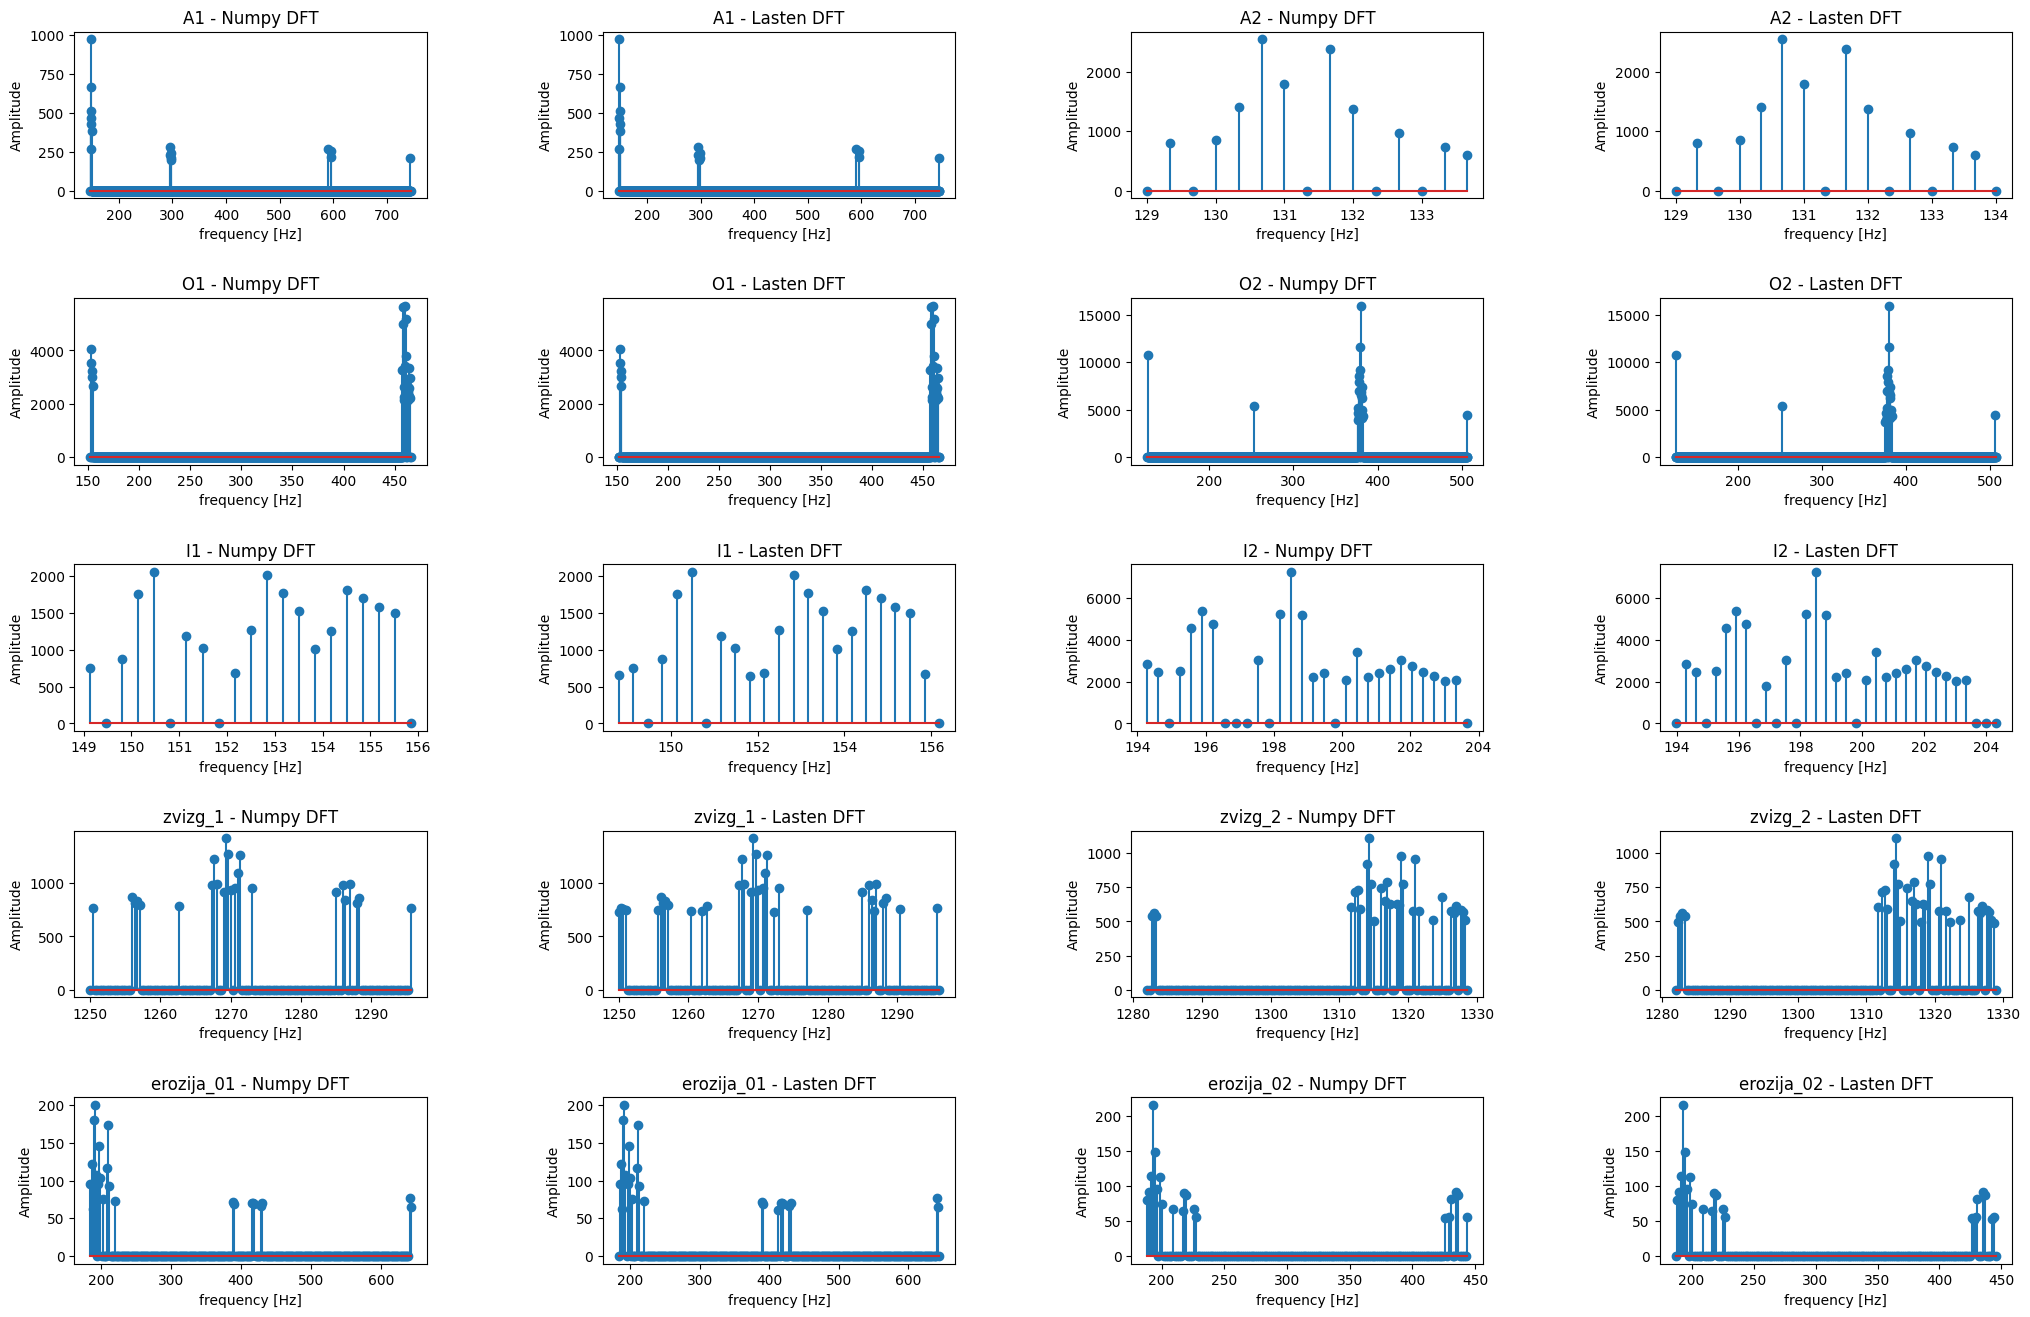

In [10]:
fig, axs = plt.subplots(len(files), 4, figsize=(25, 16), gridspec_kw={'hspace': 0.6, 'wspace': 0.5})
freq_limits = dict({
    'A': {'low': np.inf, 'high': 0},
    'I': {'low': np.inf, 'high': 0},
    'O': {'low': np.inf, 'high': 0},
})
energy_cutoff = 1.0

for i, file_pair in enumerate(files):
    for j, file in enumerate(file_pair):
        Ys, freq, min_freq, max_freq = numpy_fft_analysis(file, energy_cutoff)
        axs[i, j * 2].stem(freq, np.abs(Ys))
        axs[i, j * 2].set_title(f'{file} - Numpy DFT')
        axs[i, j * 2].set_ylabel('Amplitude')
        axs[i, j * 2].set_xlabel('frequency [Hz]')

        # Ys, freq = dftCompelex(file, (min_freq, max_freq), energy_cutoff)
        Ys, freq = dft2Real(file, (min_freq, max_freq), energy_cutoff)
        # Ys, freq = dft1Real(file, (min_freq, max_freq), energy_cutoff)
        axs[i, j * 2 + 1].stem(freq, np.abs(Ys))
        axs[i, j * 2 + 1].set_title(f'{file} - Lasten DFT')
        axs[i, j * 2 + 1].set_ylabel('Amplitude')
        axs[i, j * 2 + 1].set_xlabel('frequency [Hz]')

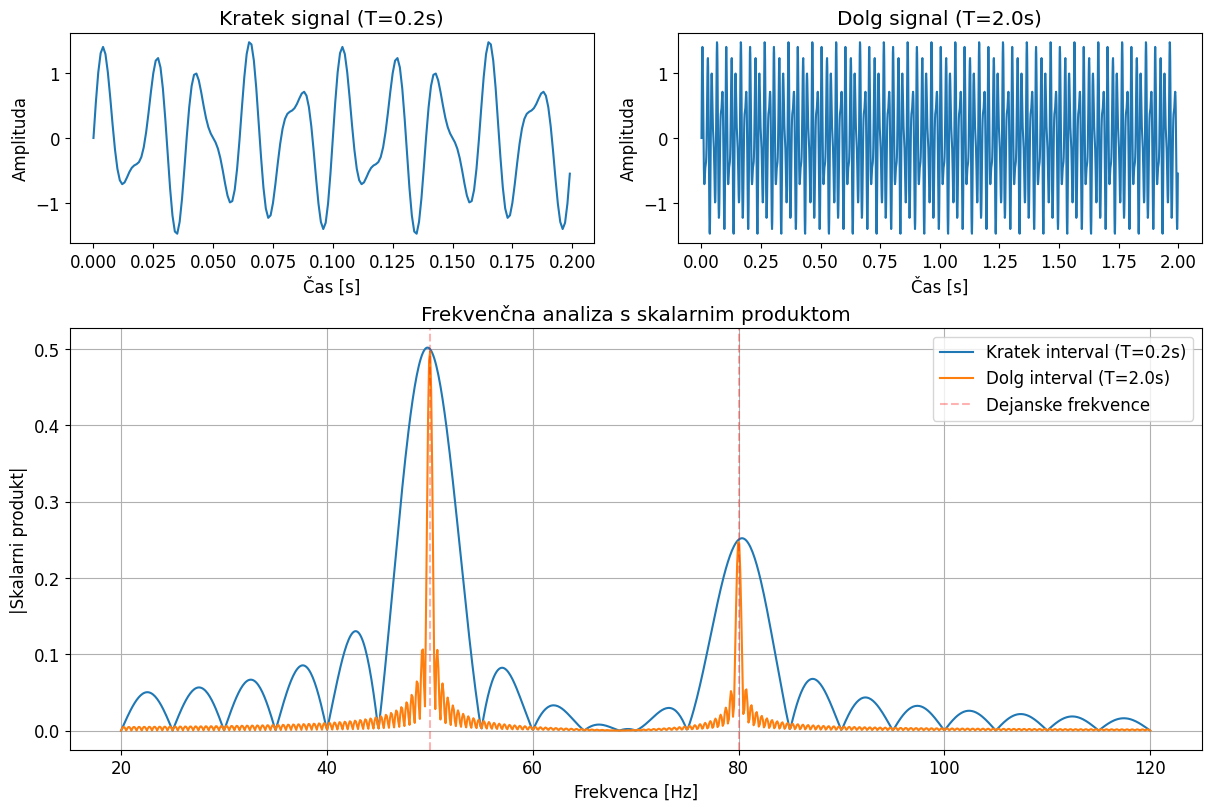

In [4]:

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

fs = 1000
t_long = np.arange(0, 2.0, 1/fs)  # 2 sekundi
t_short = np.arange(0, 0.2, 1/fs)  # 0.2 sekunde

f1, f2 = 50, 80
signal_long = np.sin(2*np.pi*f1*t_long) + 0.5*np.sin(2*np.pi*f2*t_long)
signal_short = np.sin(2*np.pi*f1*t_short) + 0.5*np.sin(2*np.pi*f2*t_short)

def compute_frequency_response(signal, t, freq_range):
    results = []
    for f in freq_range:
        test_wave = np.exp(1j*2*np.pi*f*t)
        dot_product = np.sum(signal * np.conj(test_wave)) / len(signal)
        results.append(np.abs(dot_product))
    return np.array(results)

freq_range = np.linspace(20, 120, 1000)

response_short = compute_frequency_response(signal_short, t_short, freq_range)
response_long = compute_frequency_response(signal_long, t_long, freq_range)

fig = plt.figure(constrained_layout=True)
gs = GridSpec(3, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(t_short, signal_short)
ax0.set_title('Kratek signal (T=0.2s)')
ax0.set_xlabel('Čas [s]')
ax0.set_ylabel('Amplituda')

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(t_long, signal_long)
ax1.set_title('Dolg signal (T=2.0s)')
ax1.set_xlabel('Čas [s]')
ax1.set_ylabel('Amplituda')

# Frekvenčni odziv
ax2 = fig.add_subplot(gs[1:, :])
ax2.plot(freq_range, response_short, label='Kratek interval (T=0.2s)')
ax2.plot(freq_range, response_long, label='Dolg interval (T=2.0s)')
ax2.set_xlabel('Frekvenca [Hz]')
ax2.set_ylabel('|Skalarni produkt|')
ax2.set_title('Frekvenčna analiza s skalarnim produktom')
ax2.axvline(f1, color='red', linestyle='--', alpha=0.3, label='Dejanske frekvence')
ax2.axvline(f2, color='red', linestyle='--', alpha=0.3)
ax2.legend()
ax2.grid(True)

plt.show()